In [1]:
# imports
import sys, os
sys.path.append(os.getcwd()+'/code')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import Algorithms
from data_streamer import Streamer, MultiStreamer

In [2]:
# constants
train_data_file=[os.getcwd() + '/data/toy_data_train_view1.csv', os.getcwd() + '/data/toy_data_train_view2.csv']
validation_data_file=[os.getcwd() + '/data/toy_data_test_view1.csv', os.getcwd() + '/data/toy_data_test_view2.csv']
assert os.path.isfile(train_data_file[0])
assert os.path.isfile(train_data_file[1])
assert os.path.isfile(validation_data_file[0])
assert os.path.isfile(validation_data_file[1])
k = 2 # dimensionality of representations
dx, dy = 3, 2 # dimensionality of input
learning_rate = 1 # initial learning rate
validation_freq = 1000 # how many training steps in between validations

In [3]:
# util functions to compute best CCA loss
def inv_sqrt(x):
    # inverse squareroot of symmetric matrix
    values,vectors=np.linalg.eigh(x)
    out=np.dot(vectors,np.diag(np.reciprocal(np.sqrt(values))))
    out=np.dot(out,vectors.T)
    return out

def matrix_product(array):
    # return the product of the matrices in the array
    assert len(array)>1
    out=np.dot(array[0],array[1])
    for x in array[2:]:
        out=np.dot(out,x)
    return out

In [4]:
# data streamer and algorithm
train_stream = MultiStreamer(train_data_file).get_stream()
algorithm=Algorithms.msg_cca({'dx': dx, 'dy': dy, 'k': k, 'learning_rate': learning_rate})
# load validation data at once to make validation faster
validation_data=[[],[]]
for point in MultiStreamer(validation_data_file).get_stream():
    x,y=point
    validation_data[0].append(x)
    validation_data[1].append(y)
validation_data[0]=np.stack(validation_data[0],axis=0)
validation_data[1]=np.stack(validation_data[1],axis=0)

In [5]:
# placeholders for loss
validation_loss, training_loss, max_training_loss = [], [], []
training_batch = [[],[]]
# main loop
counter=0
for point in train_stream:
    counter+=1
    algorithm.step(point)
    training_batch[0].append(point[0])
    training_batch[1].append(point[1])
    if counter%validation_freq==0:
        loss=algorithm.loss(validation_data)
        loss/=(validation_data[0].shape[0]*k)
        validation_loss.append(loss)
        training_batch[0]=np.stack(training_batch[0],axis=0)
        training_batch[1]=np.stack(training_batch[1],axis=0)
        loss=algorithm.loss(training_batch)
        loss/=(training_batch[0].shape[0]*k)
        training_loss.append(loss)
        # for information, compute the loss for the non-stochastic, closed form solution
        # our training loss couldn't be lower than that
        H=np.concatenate(training_batch,axis=1)
        # covariance matrices
        mu=np.mean(H,axis=0,keepdims=True)
        centered_h=H-mu
        C=(1./H.shape[0])*np.dot(centered_h.T,centered_h)
        C_xx=C[:dx,:dx]
        C_yy=C[-dy:,-dy:]
        C_xy=C[:dx,-dy:]
         # 1.1. matrix square roots
        identity=np.eye(dx,dtype=float)
        reg_x=np.linalg.norm(C_xx,ord=2)*0 # no regularization
        inv_sqrt_x=inv_sqrt(\
                C_xx+reg_x*identity) # inverse sqrt of c_xx
        identity=np.eye(dy,dtype=float)
        reg_y=np.linalg.norm(C_yy,ord=2)*0 # no regularization
        inv_sqrt_y=inv_sqrt(\
                C_yy+reg_y*identity) # inverse sqrt of c_yy
        tmp=matrix_product([inv_sqrt_x,C_xy,inv_sqrt_y])
        _,D,_=np.linalg.svd(tmp)
        loss=np.sum(D[:k])/k
        max_training_loss.append(loss) 
        training_batch=[[],[]]

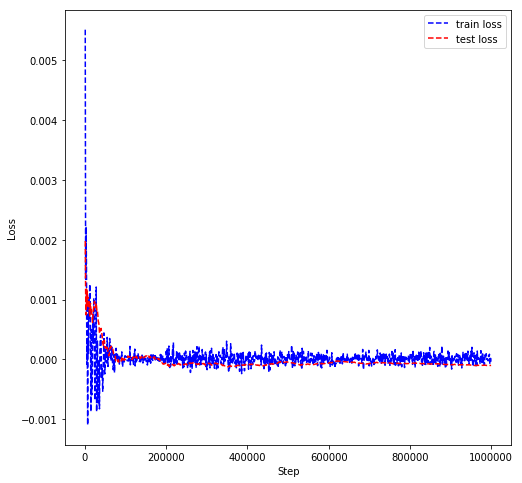

In [7]:
# plot the train and test loss
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Loss')
#plt.yscale('log')
x_scale=[x*validation_freq for x in range(1,len(training_loss)+1)]
plt.plot(x_scale, training_loss, '--b', label='train loss')
plt.plot(x_scale, validation_loss, '--r', label='test loss')
#plt.plot(x_scale, max_training_loss, '--k', label='train loss upper bound')
_ = plt.legend()